In [1]:
import numpy as np
import numpy
import argparse
import os
import cv2

import torch
import torch.nn as nn
import torchvision
import torch.utils.data
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from PIL import Image
from engine import train_one_epoch, evaluate
import pandas as pd
from tqdm import tqdm

import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt

import utils
import transforms as T
import time

from scipy import ndimage
from skimage.feature import corner_harris, corner_peaks, corner_subpix
from skimage.feature import peak_local_max

In [2]:
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [3]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    model.backbone.body.conv1 = nn.Conv2d(36, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [4]:
class StarDataset(object):
    def __init__(self, path, transforms, window_size):
        self.root = path
        self.transforms = transforms
        pth = os.listdir(path)
        self.label_sequences = []

        self.dir_paths = []
        if os.path.isdir(path):
            self.dir_paths.append(path + '/')
            print(f"Loaded {path}")

        self.window_size = window_size
        self.seq_indexs = []
        self.seq_indexs.append((0, 0, len(pth)))

    def __len__(self):
        return self.seq_indexs[-1][-1]

    def __getitem__(self, idx):
        # load images and masks
        for i, start, end in self.seq_indexs:
            if idx >= start and idx < end:
                real_idx = idx - start

                if real_idx > 3:
                    entire_data1 = np.load(self.dir_paths[i] + '/' + str(int(real_idx) - 3) + ".npy", allow_pickle=True)
                    entire_data2 = np.load(self.dir_paths[i] + '/' + str(int(real_idx) - 2) + ".npy", allow_pickle=True)
                    entire_data3 = np.load(self.dir_paths[i] + '/' + str(int(real_idx) - 1) + ".npy", allow_pickle=True)
                    entire_data4 = np.load(self.dir_paths[i] + '/' + str(int(real_idx) + 0) + ".npy", allow_pickle=True)
                else:
                    entire_data1 = np.load(self.dir_paths[i] + '/' + str(int(real_idx)) + ".npy", allow_pickle=True)
                    entire_data2 = entire_data1
                    entire_data3 = entire_data1
                    entire_data4 = entire_data1

                data1 = entire_data1[0]
                data2 = entire_data2[0]
                data3 = entire_data3[0]
                data4 = entire_data4[0]
                
                masks = entire_data4[1]

                break

        input_data = self.preprocessing(data1, data2, data3, data4)
        return input_data, torch.as_tensor(np.array(masks), dtype=torch.uint8)

    def preprocessing(self, data1, data2, data3, data4):
        # 0 ground 1 air 2 building 3 spell 4 ground 5 air 6 building 7 spell 8 resource 9 vision 10 terrain
        temp = np.zeros([self.window_size, 9, data1.shape[1], data1.shape[2]])

        temp[0] = data1
        temp[1] = data2
        temp[2] = data3
        temp[3] = data4

        data = temp
        data = data.reshape(self.window_size * data.shape[1], data.shape[2], -1)
        # #data = data.reshape(self.window_size*data.shape[0],data.shape[1],-1)
        # label = np.array([label[0]/3456, label[1]/3720])
        return torch.FloatTensor(data)

In [ ]:
testing_replay = ["212"]
datset_dir = "C:/Users/joo/PycharmProjects/starcraft_replay_reconstructor-devel/starcraft_replay_reconstructor-devel/result/"
model_dir = "C:/Users/joo/PycharmProjects/Automatic-Observer-for-StarCraft/save_models/jht/"

for i in testing_replay:    
    replay_dir = datset_dir + str(i)
    replay_name = int(replay_dir.split('/')[-1])
    print(replay_name)
    dataset = StarDataset(replay_dir, get_transform(train=False), window_size=4)
    
    dataset_len = len(dataset)    
    Start, End, Step = 0, len(dataset), 1
    test_img_array = []
    test_img_one_channel_array = []
    test_target_array = []

    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    num_classes = 2
    model = get_model_instance_segmentation(num_classes)
    model.load_state_dict(torch.load(model_dir+"model_28.pth"))
    model.to(device)
    model.eval()

    print("dataset_size:", End)
    for i in range(Start, End, Step):
        img_t = dataset[i][0]
        target_t = dataset[i][1]
        test_img_array.append(img_t)
        img_one_channel = img_t.sum(axis=0, keepdim=True)
        test_img_one_channel_array.append(img_one_channel)
        test_target_array.append(target_t)

    print("input load")
    vpx_array = []
    vpy_array = []
    predictions = []
    with torch.no_grad():
        for idx, i in tqdm(enumerate(test_img_array)):
            prediction = model(torch.unsqueeze(i, 0).to(device))
            if prediction[0]["boxes"].shape[0] == 0:
                prediction = model(torch.unsqueeze(i - 1, 0).to(device))
                vpx = int(prediction[0]["boxes"][0][0]) * 32
                vpy = int(prediction[0]["boxes"][0][1]) * 32
            else:
                vpx = int(prediction[0]["boxes"][0][0]) * 32
                vpy = int(prediction[0]["boxes"][0][1]) * 32
            predictions.append(prediction)
            if idx % 500 == 0:
                print("idx:  ", idx)
            vpx_array.append(vpx)
            vpy_array.append(vpy)
    
#     os.makedirs("./saved_xy/jht_20_gen/", exist_ok=True)
#     temp = np.zeros((dataset_len, 1))
#     for i in range(0, dataset_len):
#         temp[i] = int(i * 8)
#     temp2 = np.zeros((int(temp.max()), 1))
#     for i in range(0, int(temp.max())):
#         temp2[i] = i

#     dataset_temp = pd.DataFrame({"frame": temp[:, 0], "vpx": vpx_array[:], "vpy": vpy_array[:]})
#     dataset_temp2 = pd.DataFrame({"frame": temp2[:, 0]})
#     dataset = pd.merge(left=dataset_temp2, right=dataset_temp, how="left", on="frame")
#     dataset = dataset.fillna(method="ffill")
#     dataset.to_csv("./saved_xy/jht_20_gen/" + str(replay_name) + ".rep.vpd", header=True, index=False)
    

    print("saved")

212
Loaded C:/Users/joo/PycharmProjects/starcraft_replay_reconstructor-devel/starcraft_replay_reconstructor-devel/result/212


C:\Users\joo\.conda\envs\starcraft\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
C:\Users\joo\.conda\envs\starcraft\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


dataset_size: 3531


In [ ]:
plt.imshow(predictions[300][0]['masks'][0].sum(axis=0).mul(255).byte().cpu().detach().numpy())
# print(predictions[300][0]['masks'][0].sum())
plt.show()


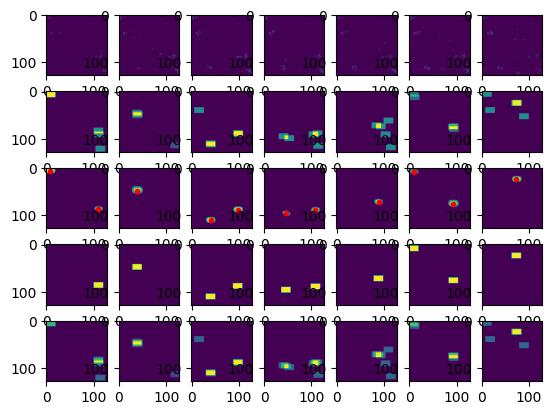

In [24]:
plot_len = int(len(test_img_array))
plot_len = len(test_img_array)
plot_len = int((2001-800)/200)+1
for idx,i in enumerate(range(800,2001,200)):

    a123 = test_target_array[i].sum(axis=0).detach().numpy().astype('float32')
    blur2 = cv2.GaussianBlur(a123, (19,11), 0)
    blur2 = np.where(blur2 <= 1.1, 0, blur2)
    coordinates = peak_local_max(blur2, min_distance=7)   
    
    aa_zero = np.zeros((128,128))
    for j in coordinates:
        x = j[0]
        y = j[1]
        aa_zero[x-6:x+6,y-10:y+10]=1
    
    plt.subplot(5,plot_len,idx+1)
#     print(test_img_array[i][:8].sum(axis=0).detach().numpy().shape)
    plt.imshow(test_img_array[i][:8].sum(axis=0).detach().numpy())
    plt.subplot(5,plot_len,idx+1+ plot_len)    
    plt.imshow(test_target_array[i].sum(axis=0).detach().numpy())
    plt.subplot(5,plot_len,idx+1+ plot_len*2)   
    plt.plot(coordinates[:, 1], coordinates[:, 0], 'r.')
    
    plt.imshow(blur2)    
    
    plt.subplot(5,plot_len,idx+1+plot_len*3)
    plt.imshow(aa_zero)
    plt.subplot(5,plot_len,idx+1+plot_len*4)
    plt.imshow(a123+aa_zero)

plt.savefig("result55.png",dpi=300)#,bbox_inches=None,pad_inches=300)#, bbox_inches='tight', pad_inches=10)
plt.show()   




tensor([7.6461e-02, 1.0893e+02, 1.9059e+01, 1.1993e+02], device='cuda:0')
tensor([38.4043, 46.0906, 57.4160, 57.0964], device='cuda:0')
tensor([ 26.0977, 106.0123,  45.0946, 116.9710], device='cuda:0')
tensor([107.7055,  77.8961, 126.7991,  89.0077], device='cuda:0')
tensor([ 85.3164,  81.8458, 104.3189,  92.8503], device='cuda:0')
tensor([ 97.0071,  57.2329, 115.9983,  68.2425], device='cuda:0')


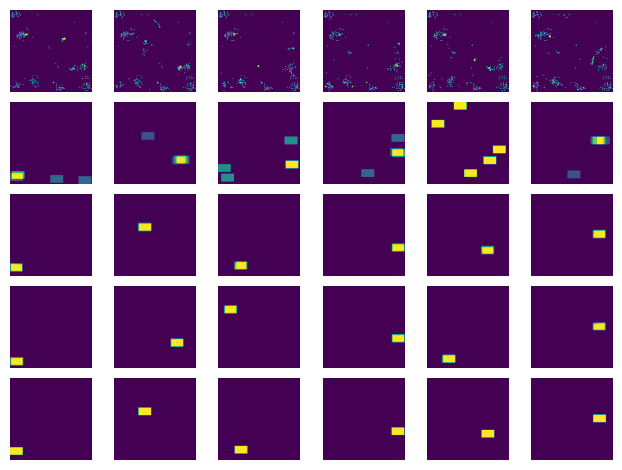

In [22]:
from matplotlib import cm

plot_len = int((3001 - 1500-150*5)/150)+1
for idx,i in enumerate(range(1500+150*5,3001,150)):

    a123 = test_target_array[i].sum(axis=0).detach().numpy().astype('float32')
    blur2 = cv2.GaussianBlur(a123, (19,11), 0)
    blur2 = np.where(blur2 <= 1.1, 0, blur2)
    coordinates = peak_local_max(blur2, min_distance=7)   
    
    aa_zero = np.zeros((128,128))
    for j in coordinates:
        x = j[0]
        y = j[1]
        aa_zero[x-6:x+6,y-10:y+10]=1
        
    acac = test_img_array[i][:8].sum(axis=0).detach().numpy()    
    acac = np.where(acac >= 1, 1.0, 0.0)
    
    plt.subplot(5,plot_len,idx+1)         
    plt.tight_layout()
    plt.axis('off')    
    plt.imshow(acac)
   
    plt.subplot(5,plot_len,idx+1+plot_len*1)
    plt.tight_layout()
    plt.axis('off')
    plt.imshow(test_target_array[i].sum(axis=0).mul(255).detach().numpy().astype('float32'))
    
    plt.subplot(5,plot_len,idx+1+plot_len*2)         
    plt.tight_layout()
    plt.axis('off')
    plt.imshow(predictions[i][0]['masks'][0].sum(axis=0).mul(255).byte().cpu().detach().numpy())
            
    plt.subplot(5,plot_len,idx+1+plot_len*3)
    plt.tight_layout()
    plt.axis('off')
    plt.imshow(predictions[i-10][0]['masks'][0].sum(axis=0).mul(255).byte().cpu().detach().numpy())
#     print(predictions[i][0]['boxes'][0])
    
    coordinates1 = predictions[i][0]['boxes'][0]
    yy1 = np.zeros((128,128))
#     for j in coordinates1:
#         y = j[1]
#         x = j[0]
#         aa_zero1[y-6:y+6,x-10:x+10]=1
    yy1[int(predictions[i][0]['boxes'][0][1]):int(predictions[i][0]['boxes'][0][1]) + 12, int(predictions[i][0]['boxes'][0][0]):int(predictions[i][0]['boxes'][0][0]) + 20] = 1

    
    plt.subplot(5,plot_len,idx+1+plot_len*4)
    plt.tight_layout()
    plt.axis('off')
    plt.imshow(yy1)

plt.tight_layout()
plt.savefig("result_late_screen1.png",dpi=500,pad_inches=0,bbox_inches='tight')
plt.show()




tensor([107.7046, 111.9415, 126.7349, 122.9725], device='cuda:0')
tensor([60.3700, 68.0347, 79.3478, 79.0216], device='cuda:0')
tensor([ 86.3623,  83.3532, 105.3657,  94.3632], device='cuda:0')
tensor([ 42.6199,  92.5804,  61.5985, 103.5060], device='cuda:0')
tensor([107.9148, 109.3421, 126.9215, 120.3743], device='cuda:0')
tensor([ 91.8037,  83.2498, 110.8068,  94.2458], device='cuda:0')
tensor([ 28.8608, 105.4050,  47.8791, 116.4138], device='cuda:0')


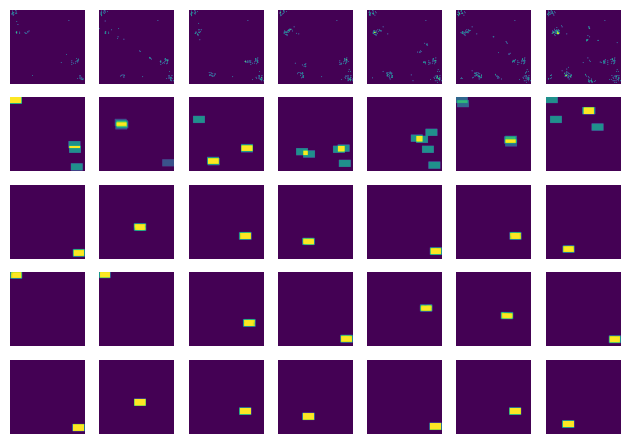

In [23]:
from matplotlib import cm

plot_len = int(len(test_img_array))
plot_len = len(test_img_array)
plot_len = int((2001-800)/200)+1
for idx,i in enumerate(range(800,2001,200)):

    a123 = test_target_array[i].sum(axis=0).detach().numpy().astype('float32')
    blur2 = cv2.GaussianBlur(a123, (19,11), 0)
    blur2 = np.where(blur2 <= 1.1, 0, blur2)
    coordinates = peak_local_max(blur2, min_distance=7)   
    
    aa_zero = np.zeros((128,128))
    for j in coordinates:
        x = j[0]
        y = j[1]
        aa_zero[x-6:x+6,y-10:y+10]=1
        
    acac = test_img_array[i][:8].sum(axis=0).detach().numpy()    
    acac = np.where(acac >= 1, 1.0, 0.0)
    
    plt.subplot(5,plot_len,idx+1)         
    plt.tight_layout()
    plt.axis('off')    
    plt.imshow(acac)
   
    plt.subplot(5,plot_len,idx+1+plot_len*1)
    plt.tight_layout()
    plt.axis('off')
    plt.imshow(test_target_array[i].sum(axis=0).mul(255).detach().numpy().astype('float32'))
    
    plt.subplot(5,plot_len,idx+1+plot_len*2)         
    plt.tight_layout()
    plt.axis('off')
    plt.imshow(predictions[i][0]['masks'][0].sum(axis=0).mul(255).byte().cpu().detach().numpy())
            
    plt.subplot(5,plot_len,idx+1+plot_len*3)
    plt.tight_layout()
    plt.axis('off')
    plt.imshow(predictions[i][0]['masks'][1].sum(axis=0).mul(255).byte().cpu().detach().numpy())
#     print(predictions[i][0]['boxes'][0])
    
    coordinates1 = predictions[i][0]['boxes'][0]
    yy1 = np.zeros((128,128))
#     for j in coordinates1:
#         y = j[1]
#         x = j[0]
#         aa_zero1[y-6:y+6,x-10:x+10]=1
    yy1[int(predictions[i][0]['boxes'][0][1]):int(predictions[i][0]['boxes'][0][1]) + 12, int(predictions[i][0]['boxes'][0][0]):int(predictions[i][0]['boxes'][0][0]) + 20] = 1

    
    plt.subplot(5,plot_len,idx+1+plot_len*4)
    plt.tight_layout()
    plt.axis('off')
    plt.imshow(yy1)

plt.tight_layout()
plt.savefig("result_late_screen1.png",dpi=500,pad_inches=0,bbox_inches='tight')
plt.show()




In [ ]:
from matplotlib import cm

plot_len = int((3001 - 1500-150*5)/150)+1
for idx,i in enumerate(range(1500+150*5,3001,150)):

    a123 = test_target_array[i].sum(axis=0).detach().numpy().astype('float32')
    blur2 = cv2.GaussianBlur(a123, (19,11), 0)
    blur2 = np.where(blur2 <= 1.1, 0, blur2)
    coordinates = peak_local_max(blur2, min_distance=7)   
    
    aa_zero = np.zeros((128,128))
    for j in coordinates:
        x = j[0]
        y = j[1]
        aa_zero[x-6:x+6,y-10:y+10]=1
        
    acac = test_img_array[i][:8].sum(axis=0).detach().numpy()    
    acac = np.where(acac >= 1, 1.0, 0.0)
    
    plt.subplot(8,plot_len,idx+1)         
    plt.tight_layout()
    plt.axis('off')    
    plt.imshow(acac)
   
    plt.subplot(8,plot_len,idx+1+plot_len*1)
    plt.tight_layout()
    plt.axis('off')
    plt.imshow(test_target_array[i].sum(axis=0).mul(255).detach().numpy().astype('float32'))
    
    plt.subplot(8,plot_len,idx+1+plot_len*2)         
    plt.tight_layout()
    plt.axis('off')
    plt.imshow(predictions[i][0]['masks'][0].sum(axis=0).mul(255).byte().cpu().detach().numpy())
            
    plt.subplot(8,plot_len,idx+1+plot_len*3)
    plt.tight_layout()
    plt.axis('off')
    plt.imshow(predictions[i-2][0]['masks'][0].sum(axis=0).mul(255).byte().cpu().detach().numpy())
    print(predictions[i][0]['boxes'][0])
    
    coordinates1 = predictions[i][0]['boxes'][0]
    yy1 = np.zeros((128,128))
    yy1[int(predictions[i][0]['boxes'][0][1]):int(predictions[i][0]['boxes'][0][1]) + 12, int(predictions[i][0]['boxes'][0][0]):int(predictions[i][0]['boxes'][0][0]) + 20] = 1
    
    plt.subplot(8,plot_len,idx+1+plot_len*4)
    plt.tight_layout()
    plt.axis('off')
    plt.imshow(predictions[i-4][0]['masks'][0].sum(axis=0).mul(255).byte().cpu().detach().numpy())
    
    plt.subplot(8,plot_len,idx+1+plot_len*5)
    plt.tight_layout()
    plt.axis('off')
    plt.imshow(predictions[i-6][0]['masks'][0].sum(axis=0).mul(255).byte().cpu().detach().numpy())
    
    plt.subplot(8,plot_len,idx+1+plot_len*6)
    plt.tight_layout()
    plt.axis('off')
    plt.imshow(predictions[i-8][0]['masks'][0].sum(axis=0).mul(255).byte().cpu().detach().numpy())
    
    plt.subplot(8,plot_len,idx+1+plot_len*7)
    plt.tight_layout()
    plt.axis('off')
    plt.imshow(predictions[i-10][0]['masks'][0].sum(axis=0).mul(255).byte().cpu().detach().numpy())

plt.tight_layout()
plt.savefig("result_late_screen1.png",dpi=500,pad_inches=0,bbox_inches='tight')
plt.show()




In [ ]:
len(test_target_array)

In [ ]:
yy1[int(predictions[i][0]['boxes'][0][1]):int(predictions[i][0]['boxes'][0][1]) + 12, int(predictions[i][0]['boxes'][0][0]):int(predictions[i][0]['boxes'][0][0]) + 20] = 1
old = np.zeros((1,10))

cumulate_y_diff_lst = []
cumulate_x_diff_lst = []
cumulate_x_y_diff_lst = []
remove_index = []

for i in range(10,len(test_target_array), 1):
#     ymin = int(predictions[i][0]['boxes'][0][1])
#     xmin = int(predictions[i][0]['boxes'][0][0])
#     print(i)
    cumulate_y_diff = 0
    cumulate_x_diff = 0
    if len(remove_index) != 0:
        if i < (remove_index[-1]+10):
            #print(i) 
            continue
        else:
            for j in range(i,i-10,-1):
                y_diff = abs(int(predictions[j][0]['boxes'][0][1]+12)-int(predictions[j-1][0]['boxes'][0][1]+12))
                x_diff = abs(int(predictions[j][0]['boxes'][0][0]+20)-int(predictions[j-1][0]['boxes'][0][1]+20))
                cumulate_y_diff += y_diff
                cumulate_x_diff += x_diff
            if x_diff > 60 or y_diff > 36: #or np.square(x_diff*x_diff + y_diff*y_diff)> 20*20+12*12:
                print("Start newepisode")
                remove_index.append(i)
                continue
                
            cumulate_y_diff_lst.append(cumulate_y_diff)
            cumulate_x_diff_lst.append(cumulate_x_diff)  
    else:
        for j in range(i,i-10,-1):
            y_diff = abs(int(predictions[j][0]['boxes'][0][1]+12)-int(predictions[j-1][0]['boxes'][0][1]+12))
            x_diff = abs(int(predictions[j][0]['boxes'][0][0]+20)-int(predictions[j-1][0]['boxes'][0][1]+20))
            cumulate_y_diff += y_diff
            cumulate_x_diff += x_diff
            if x_diff > 20 or y_diff > 12 : #or np.square(x_diff*x_diff + y_diff*y_diff)> 20*20+12*12:
                print(i,"Start newepisode")
                remove_index.append(i)
                continue
                #break
        cumulate_y_diff_lst.append(cumulate_y_diff)
        cumulate_x_diff_lst.append(cumulate_x_diff)    
    

In [ ]:
len(remove_index)

In [ ]:
remove_index

In [ ]:
yy1[int(predictions[i][0]['boxes'][0][1]):int(predictions[i][0]['boxes'][0][1]) + 12, int(predictions[i][0]['boxes'][0][0]):int(predictions[i][0]['boxes'][0][0]) + 20] = 1
old = np.zeros((1,10))

cumulate_y_diff_lst = []
cumulate_x_diff_lst = []
cumulate_x_y_diff_lst = []
remove_index = []

for i in range(10,len(test_target_array), 1):
#     ymin = int(predictions[i][0]['boxes'][0][1])
#     xmin = int(predictions[i][0]['boxes'][0][0])
#     print(i)
    cumulate_y_diff = 0
    cumulate_x_diff = 0
    if len(remove_index) != 0:
        if i < (remove_index[-1]+10):
            #print(i) 
            continue
        else:
            for j in range(i,i-10,-1):
                y_diff = abs(int(predictions[j][0]['boxes'][0][1]+12)-int(predictions[j-1][0]['boxes'][0][1]+12))
                x_diff = abs(int(predictions[j][0]['boxes'][0][0]+20)-int(predictions[j-1][0]['boxes'][0][1]+20))
                cumulate_y_diff += y_diff
                cumulate_x_diff += x_diff
            if x_diff > 40 or y_diff > 24 : #or np.square(x_diff*x_diff + y_diff*y_diff)> 20*20+12*12:
                print("Start newepisode")
                remove_index.append(i)
                continue
                
            cumulate_y_diff_lst.append(cumulate_y_diff)
            cumulate_x_diff_lst.append(cumulate_x_diff)  
    else:
        for j in range(i,i-10,-1):
            y_diff = abs(int(predictions[j][0]['boxes'][0][1]+12)-int(predictions[j-1][0]['boxes'][0][1]+12))
            x_diff = abs(int(predictions[j][0]['boxes'][0][0]+20)-int(predictions[j-1][0]['boxes'][0][1]+20))
            cumulate_y_diff += y_diff
            cumulate_x_diff += x_diff
            if x_diff > 20 or y_diff > 12 : #or np.square(x_diff*x_diff + y_diff*y_diff)> 20*20+12*12:
                print(i,"Start newepisode")
                remove_index.append(i)
                continue
                #break
        cumulate_y_diff_lst.append(cumulate_y_diff)
        cumulate_x_diff_lst.append(cumulate_x_diff)    
    

In [ ]:
len(remove_index)

In [ ]:
from matplotlib import pyplot as plt
plt.plot(cumulate_y_diff_lst)
plt.show()

In [ ]:
from matplotlib import pyplot as plt
plt.plot(cumulate_x_diff_lst)
plt.show()

In [ ]:
from matplotlib import pyplot as plt
plt.plot(np.sqrt(np.asarray(cumulate_x_diff_lst)*np.asarray(cumulate_x_diff_lst) + np.asarray(cumulate_y_diff_lst)*np.asarray(cumulate_y_diff_lst)))
plt.show()


In [ ]:
np.sqrt(np.asarray(cumulate_x_diff_lst)*np.asarray(cumulate_x_diff_lst) + np.asarray(cumulate_y_diff_lst)*np.asarray(cumulate_y_diff_lst))

In [ ]:
cumulate_x_diff_lst